# Neural style

V tomto cvičení si vyzkoušíme tzv. přenos stylu mezi obrázky tak, jak byl původně navržen v článku [Gatys et al.: A Neural Algorithm of Artistic Style](https://arxiv.org/abs/1508.06576). Na zdrojový obrázek s obsahem (content) aplikujeme vizuální styl z jiného obrázku, čímž vznikne kombinace obou. Viz příklad:

<table>
  <tr>
    <td><img src="data/chicago.jpg" style="height: 200px;"/></td>
     <td/>+
    <td><img src="data/the_scream.jpg" style="height: 200px;"/></td>
      <td/>=
    <td><img src="data/chicago_scream.jpg" style="height: 200px;"/></td>
    </tr>
</table>

Obrázky: https://github.com/leongatys/fast-neural-style/

Princip je vysvětlen v přednášce, zde proto již jen stručně:
- máme celkem tři obrázky: obsahový (content) obrázek $p$, obrázek stylu $a$ a kombinovaný výstupní obrázek $x$
- problém je formulován jako nalezení optimálního $x$, který sdílí obsah s $p$, ale vizuální styl přebírá z $a$
- podobnost obsahů se namísto pixelů měří na úrovni příznaků z konvolučních map $F^l$ a $P^l$ extrahovaných z obrázků $x$ a $p$, přičemž $l$ značí zvolenou vrstvu
- hledáme tedy takový obr. $x$, který minimalizuje *content loss* $$L_c = \sum_{i,j}(F_{ij}^l - P_{ij}^l)^2$$
- podobnost stylů se měří pomocí gram korelačních matic $G_{ij}^l$ vypočtených z příznakové repezentace jako $$G_{ij}^l = \sum_k{F_{ik}^lF_{jk}^l}$$
- optimální $x$ tedy musí zároveň minimalizovat také $$E^l = \sum_{i,j}(G_{ij}^l - A_{ij}^l)^2$$ kde $A^l$ je gram matice extrahovaná  z $l$-té konvoluční mapy obrázku $a$
- u *style lossu* $L_s$ typicky uvažujeme více než jednu vrstvu $l$, přičemž každá pak má přizazenu váhu $w^l$ a pak $$L_s = \sum_{l \in W} w^l\cdot E^l$$
- **celkové kritérium** $L$ pak je $$L = \alpha L_c + \beta L_s$$ kde $\alpha,\beta$ jsou hyperparametry balancující důležitost obshau a stylu

In [1]:
from IPython.display import HTML
import numpy as np
from matplotlib import animation
import matplotlib.pyplot as plt
from PIL import Image
from skimage import io
import tqdm

import torch
from torchvision import transforms

import ans

In [2]:
plt.rcParams['figure.figsize'] = 12., 8.

Jak si můžete v notebooku vyzkoušet, neural style je velmi citlivý na změny rozlišení. Je tomu tak proto, že stejná konvoluční mapa $l$-té vrstvy má pro různá rozlišení různý relativní receptive field, tj. vidí jinak velkou část vstupního obrázku. Na stejné vrstvě tedy pouhou změnou rozlišení dostaneme úplně jiné příznaky a pro dosažení stejného či alespoň podobného výsledku je nutné poupravit hyperparametry algoritmu. Pro jednoduchost proto oba obrázky $p$ a $s$ normalizujeme na stejnou čtvercovou velikost.

### Upozornění

Tento notebook je nastavený na trénování s použitím GPU při rozlišení 512x512 pixelů. **Bez GPU však s tímto rozlišením bude optimalizace velmi pomalá.** Snížením rozlišení ale zároveň dojde k "rozladění" vah a kdo bude počítat pouze na CPU, bude si pravděpodobně muste pohrát s hyperparametry, především s váhami jednotlivých vrstev u style lossu.

In [3]:
# std. predzpracovani vsech PyTorch predtrenovanych modelu
normalize = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

# chceme ctvercovy obrazek o zadanem rozliseni
prep = transforms.Compose([
    transforms.Resize(512),
    transforms.CenterCrop(512),
    transforms.ToTensor(),
    normalize,
])

In [4]:
# prevod torch tensoru zpet do numpy pro ucely vizualizace
unprep = transforms.Compose([
    lambda x: x.detach().cpu().numpy(),
    lambda x: x.transpose(1, 2, 0),
    lambda x: x * np.array([0.229, 0.224, 0.225]),
    lambda x: x + np.array([0.485, 0.456, 0.406]),
    lambda x: np.uint8(255 * x.clip(0., 1.))
])

Následující funkce se bude hodit pro inicializaci obrázků náhodným obsahem.

In [5]:
def random_like(tensor, requires_grad=True, init_func=torch.randn):
    x = 0.5 + 0.1 * init_func(*tensor.shape, dtype=tensor.dtype, device=tensor.device)
    x.clamp_(0., 1.)
    x = normalize(x[0])[None]
    x.requires_grad_(requires_grad)
    return x

# Model

Stačit nám bude nějaká z předtrénovaných sítí. V původním článku byla použita VGG-19, zvolíme ji tedy i zde.

In [6]:
# u VGG nam staci pouze `features` cast, klasifikacni cast site nepotrebujeme
import torchvision

vgg = torchvision.models.vgg19(pretrained=True).features.eval()
vgg

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

Jak se píše v původním článku, o něco lepší výsledky lze dosáhnout výměnou všech max-pooling vrstev za average pooling. Učiňte tak v následující buňce.

In [7]:
#################################################################
# ZDE DOPLNIT
vgg[4] = torch.nn.AvgPool2d(kernel_size=2, stride=2, padding=0, ceil_mode=False)
vgg[9] = torch.nn.AvgPool2d(kernel_size=2, stride=2, padding=0)
vgg[18] = torch.nn.AvgPool2d(kernel_size=2, stride=2, padding=0, ceil_mode=False)
vgg[27] = torch.nn.AvgPool2d(kernel_size=2, stride=2, padding=0, ceil_mode=False)
vgg[36] = torch.nn.AvgPool2d(kernel_size=2, stride=2, padding=0, ceil_mode=False)
#################################################################

In [8]:
vgg

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (19): Conv2d(256

In [9]:
vgg.cuda();

In [10]:
device = next(vgg.parameters()).device
device

device(type='cuda', index=0)

Jelikož síť neučíme, zablokujeme výpočet gradientů.

In [11]:
for name, par in vgg.named_parameters():
    par.requires_grad = False

# Rekonstrukce obsahu

Jako první vyzkoušíme rekonstrukci pouze za použítí obsahu, tj. bez stylu. To znamená, že budeme tvořit nějaký obrázek, který nazveme `c_rec`. Tento obrázek nainicializujeme na náhodný šum a budeme optimalizovat tak, aby měl stejnou příznakovou reprezentaci jako content obrázek `c_img`.

Pozn: v notebooku jsou proměnné související s obsahem pojmenovány s přepodnou `c_`, pro styl je zvolena předpona `s_` a pro jejich kombinaci `t_`.

## Content obrázek

In [12]:
c_img = io.imread('data/chicago.jpg')
c_img = prep(Image.fromarray(c_img))[None]
c_img = c_img.to(device)
c_img.device, c_img.dtype, c_img.shape

(device(type='cuda', index=0), torch.float32, torch.Size([1, 3, 512, 512]))

In [13]:
plt.imshow(unprep(c_img[0]));

## Extrakce příznaků obsahu

Byť u rekonstrukce pouze z obsahu se to spíše netýká, pro výpočet style lossu budeme potřebovat příznaky z více než jedné vnitřních vrstev sítě. Při zavolání `vgg.forward(x)`  nám však PyTorch vrátí pouze výstup z poslední vrstvy sítě, přičemž k mezivýpočtům nemáme přístup. Existuje několik přístupů, jak toto omezení obejít:

1. Mohli bychom vytvořit vlastní kopii třídy `VGG`, u níž bychom přepsali metodu `forward` tak, aby vracela nebo někam ukládala vypočtené příznaky z vnitřních vrstev. Zřejmou nevýhodou tohoto postupu je časová náročnost a to především při případné výměně modelu za jinou architekturu, kdy bychom museli dopředný průchod psát vždy celý znovu.

2. Můžeme využít faktu, ze `features` část architektury `VGG` je v PyTorch typu `torch.nn.Sequential` a tedy dopředný průchod je pouze sekvenční aplikace vnitřních modelů tak, jak za sebou byly definovány při vytvoření. Mohli bychom tedy ve `for` cyklu postupně počítat příznaky a kontrolovat, zda číslo vrstvy je v nějakém poli, které označuje, jaké vrstvy nás zajímají. Nevýhodou je, že tento postup bude fungovat jen pro takto jednoduché sítě.

3. **Použijeme PyTorch koncept hooků, což jsou callback funkce, které se volají při dopředném a zpětném průchodu u každé vrstvy.**

Pytorch umožňuje registrovat hook funkci pro dopředný průchod nějakého modulu metodou `module.register_forward_hook`. Funkce jako parametr převezme jinou callback funkci, která se zavolá **po dokončení** dopředného průchodu tímto modulem a dostane jako argumenty aktuální modul, jeho vstup a vypočtený výstup. Právě výstup si pak v této callback funkci jednoduše uložíme do nějakého pole.

Následující funkce pro extrakci příznaků tento postup implementuje. *Při každém* dopředném průchodu sítí zaregistruje dopředné hooky, zavolá dopředný průchod, a hooky znovu odregistruje. Registrace je poměrně efektivní a ke zvoleným submodulům sítě pouze přidá do pole hooků naše callbacky. Naprostá většina času této funkce tedy stále bude tvořena samotným výpočtem konvolučních příznaků, tj. dopředným průchodem sítí.

In [14]:
def forward_ex(x, model, layers):
    """
    Provede dopredny pruchod `y = model(x)` a krome `y` zaroven vrati i vystupy vrstev uvedenych v poli `layers`
    
    Vystup:
        y ... vysledek dopredneho pruchodu `y = model(x)`
        cache ... slovnik formatu `{vrstva: vystup}` pro vrstvy obsazene v `layers`
    """
    hooks = []
    cache = {}
    for name in layers:
        module = getattr(model, name)
        def _store_output(m, i, o, name=name):
            cache[name] = o
        handle = module.register_forward_hook(_store_output)
        hooks.append(handle)
    
    x = model(x)
    
    for handle in hooks:
        handle.remove()
    
    return x, cache

Ve výpisu výše je vidět struktura sítě včetně názvů. Pro reprezentaci zvolíme např. vrstvu `'conv4_2'`, která byla použita v článku Gatyse a kol. `torch.nn.Sequential` má defaultně vrstvy pojmenované pouze číslem, správnou tedy najděte např. odpočítáním :-) Požadované vrstvy zadefinujeme jako pole názvů.

In [15]:
#################################################################
# ZDE DOPLNIT

c_layers = ['21']

#################################################################

Získáme příznaky:

In [16]:
c_targets = forward_ex(c_img, vgg, c_layers)[1]  # prvni vystup zahodime, zajimaji nas pouze vnitrni vrstvy

Nepotřebujeme v paměti držet celou historii výpočtu proměnné `c_targets`. Následujícím kódem ji "zahodíme".

In [17]:
c_targets = {l: c_targets[l].detach() for l in c_layers}

Vytvoříme nový obrázek `c_rec` a inicializujeme ho náhodnými hodnotami.

In [18]:
c_rec = random_like(c_img)
c_rec.device, c_rec.dtype, c_rec.shape

(device(type='cuda', index=0), torch.float32, torch.Size([1, 3, 512, 512]))

In [19]:
plt.imshow(unprep(c_rec[0]))

## Optimalizace

Pro optimalizaci stejně jako v původním článku použijeme metodu [L-BFGS](https://en.wikipedia.org/wiki/Broyden%E2%80%93Fletcher%E2%80%93Goldfarb%E2%80%93Shanno_algorithm). L-BFGS patří do skupiny [kvazi-newtonovských](https://en.wikipedia.org/wiki/Quasi-Newton_method), které v každém kroku lokálně aproximují povrch kvadratickou funkcí (např. parabola v 1D), u níž se snaží najít minimum. Viz obrázek:

![Newtonova metoda](https://ardianumam.files.wordpress.com/2017/09/newtonmethodforoptim1.jpg)
Zdroj: [https://ardianumam.wordpress.com/2017/09/27/newtons-method-optimization-derivation-and-how-it-works/](https://ardianumam.wordpress.com/2017/09/27/newtons-method-optimization-derivation-and-how-it-works/)

V následujícím kroku se pak přesuneme do tohoto minima a proces se opakuje. K aproximaci paraboloidem je však potřeba matice druhých derivací ([Hessián](https://en.wikipedia.org/wiki/Hessian_matrix)), jejíž výpočet je náročný, což *kvazi-* metody obcházejí aproximací pomocí prvních derivací ([Jakobián](https://en.wikipedia.org/wiki/Jacobian_matrix_and_determinant)). Výhodou těchto metod je  automatický výpočet velikosti kroku a není tedy u nich potřeba nastavovat learning rate. Pro běžné učení sítí s mini-dávkami (minibatch) se však nehodí, protože jsou citlivé na změny lokální charakteristiky povrchu optimalizované funkce, k čemuž u minibatch učení dochází, jelikož s každou dávkou navzorkujeme jiná data. U style transferu žádné minibatche nemáme, díky čemuž se vlastnosti optimalizované funkce nemění a použitím L-BFGS dosáhneme rychlejší konvergence.

In [20]:
c_opt = torch.optim.LBFGS([c_rec])

In [21]:
c_stats = ans.Stats(0.)
c_stats.new_epoch()
c_rec_history = []

V PyTorch je při použití 2nd-order metody L-BFGS nutné poupravit trénovací kód. Pro automatický výpočet velikosti kroku je nutné optimalizovanou funkci vyhodnotit vícekrát, než dojde k samotnému updatu pozice. Funkce `optimizer.step` proto vyžaduje parametr `closure`, což je naše optimalizovaná funkce, která:
1. extrahuje příznaky,
2. spočítá loss porovnáním s referencí,
3. vypočte gradienty v aktuálním bodě,
4. a vrátí hodnotu lossu.

Optimizer si ji může zavolat jako callback, kolikrát bude potřebovat. Jde vlastně o vnitřek "trénovacího" cyklu a vaším úkolem je doplnit jeho kód.

In [22]:
crit = torch.nn.MSELoss()

def c_closure():
    #################################################################
    # ZDE DOPLNIT
    
    c_rec_features = forward_ex(c_rec, vgg, c_layers)[1]
    c_loss = sum([crit(c_rec_features[l], c_targets[l]) for l in c_layers])
    c_losses_.append(float(c_loss))  # pole c_losses_ existuje mimo tuto funkci

    # zpetny pruchod
    c_loss.backward()
    #################################################################
    return c_loss

Struktura kódu pro trénování je tak o něco jednodušší. Na GTX 1070 8GB trvá jedna iterace cca 1.5 s, tzn. cyklus o 100 iteracích přibližně dvě a půl minuty. Pro kontrolu, zda optimalizace "něco dělá", stačí i mnohem méně, např. 20 iterací. Nemusíte tedy vždy čekat plnou dobu.

In [48]:
pb = tqdm.tnrange(100)
for i in pb:
    c_losses_ = []
    c_opt.step(c_closure)
    
    c_stats.append_batch_stats('train', c_loss=np.mean(c_losses_))
    pb.set_postfix(loss='{:.3f}'.format(c_stats.ravg('train', 'c_loss')), n_closures=len(c_losses_))
    if (i + 1) % 5 == 0:
        c_rec_history.append(unprep(c_rec[0]))

<ipython-input-48-15ac19ec7e31>:1: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  pb = tqdm.tnrange(100)


  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

Podle zvolené vrstvy bude vypadat i rekonstrukce. Čím vyšší vrstva, tím více detailů z původního obrázku se ztratí a reprezetnace bude odpovídat spíše "vysokoúrovňovým" příznakům. Při použítí v článku doporučené vrstvy tedy nebude rekonstrukce dokonalá a může obsahovat poměrně značné množství šumu. Při použití nižší vrstvy bude rekonstrukce mnohem čistší.

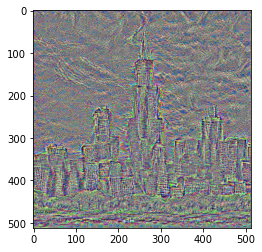

In [49]:
plt.imshow(unprep(c_rec[0]));

Pro debugovací účely může být výhodné podívat se na vývoj optimalizace. Zde je funkce pro vykreslení sekvence obrázků jako animace. Pro fungování je nutné mít v Anacondě nainstalovaný ffmpeg s podporou libx264. Obvykle vše pracuje jak má, pokud ne, pak lze balík doinstalovat příkazem `conda install -c conda-forge ffmpeg`.

In [23]:
def animate_history(img_history, figsize=None, interval=500):
    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(img_history[0], animated=True)
    
    def anim(frame):
        im.set_data(img_history[frame])
        return im,
    
    ani = animation.FuncAnimation(fig, anim, frames=len(img_history), interval=interval, blit=True)
    plt.close(fig)
    return HTML(ani.to_html5_video())

In [51]:
animate_history(c_rec_history)

Zobrazíme si i průběh lossu.

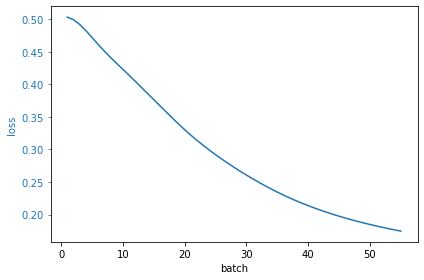

In [52]:
c_stats.plot_by_batch(left_metric='c_loss', right_metric=None, block_len=1)

# Rekonstrukce stylu

Nyní zkusíme to samé i se stylem. Pokusíme se rekonstruovat obrázek `s_img`, tentokrát ovšem pouze na základě korelačních gram matic. Tentokrát tedy budeme optimalizovat nějaký obrázek `s_rec` tak, aby tvořil stejné gram matice jako `s_img`. Vizualizujeme si tak stylovou informaci, která se později z `s_img` bude přenášet na obsahový obrázek `c_img`.

## Style obrázek

In [24]:
s_img = io.imread('data/the_scream.jpg')
s_img = prep(Image.fromarray(s_img))[None]
s_img = s_img.to(device)
s_img.device, s_img.dtype, s_img.shape

(device(type='cuda', index=0), torch.float32, torch.Size([1, 3, 512, 512]))

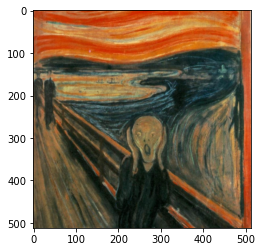

In [27]:
plt.imshow(unprep(s_img[0]));

## Extrakce příznaků stylu

Podobnost stylů se měří gram maticemi. Zadefinujeme si proto funkci, která z konvoluční mapy $F^l$ $l$-té vrstvy tyto korelační matice vyrobí. Ještě jednou vzoreček: $$G_{ij}^l = \sum_k{F_{ik}^lF_{jk}^l}$$

**Pozn.:** matice $G^l$ není ve vzorcích normalizovaná svou velikostí (výska x šířka). Namísto toho je v původním článku normalizační koeficient vytknut před závorku při výpočtu lossu, viz proměnná $M^l$ ve vztahu (4) článku Gatyse a kol. Jelikož ve fci `gramstat` je jednoduché z `fetmap` zjistit velikost, můžete normalizaci vydělením `h` x `w` zahrnout již sem.

In [28]:
def gramstat(featmap):
    """
    vstup:
      featmap ... konvolucni mapa (priznaky) o rozmerech b x c x h x w, kde b=1 je batch dimenze
    vystup:
      gram ... korelacni matice o rozmerech b x c x c
    """
    #################################################################
    # ZDE DOPLNIT
    
    featmap_copy = featmap.view(featmap.shape[0], featmap.shape[1], featmap.shape[2]*featmap.shape[3]).squeeze()
    gram = featmap_copy@featmap_copy.T
    gram /= featmap.shape[2]*featmap.shape[3]
    
    #################################################################
    
    return gram

Zvolíme konvoluční vrstvy, ze kterých styl budeme extrahovat. Na rozdíl od obsahu jich tentokrát bude více. V článku byly použity tyto vrstvy: `'conv1_1'`, `'conv2_1'`, `'conv3_1'`, `'conv4_1'` a `'conv5_1'`. Obsah nás momentálně nezajímá, a tak jako parametr `c_layers` do funkce `forward_ex` zadáme prázdné pole. Reference pro styl `s_targets` budou tentokrát gram matice.

In [29]:
#################################################################
# ZDE DOPLNIT

s_layers = ['0', '5', '10', '19', '28']

#################################################################

In [30]:
s_features = forward_ex(s_img, vgg, s_layers)[1]

Opět zahodíme výpočetní historii (graf).

In [31]:
s_features = {l: s_features[l].detach() for l in s_layers}

Z konvolučních map vytvoříme gram matice, které teprve budou sloužit jako reference pro optimalizaci.

In [32]:
#################################################################
# ZDE DOPLNIT

s_targets = {l: gramstat(s_features[l]) for l in s_layers}

#################################################################

## Váhy

Nyní jedno z klíčových "šamanství" style transferu, kterým jsou zvolené váhy. Jejich hodnoty mají výrazný vliv na výslednou podobu obrázku (vyzkoušejte si!). V původním článku doporučují nastavit váhy nepřímo úměrně druhé mocnině počtu filtrů ve vrstvě, tak se toho raději budeme držet. Váhy tedy nastavte dle
$$
w^l = \frac{\omega}{4W_l^2H_l^2C_l^2}
$$
kde $W_l$, $H_l$ a $C_l$ jsou šířka, výška a počet filtrů konv. mapy vrstvy $l$. $\omega$ je jakási "bulharská konstanta", která bohužel rozhoduje, zda celý algoritmus bude či nebude fungovat. Kvůli zaokrouhlování je důležité, aby style loss měl dostatečnou "energii". V opačném případě vyjdou velmi malé hodnoty gradientů, PyTorch je bude v rámci optimalizace považovat za nulu a během optimalizace se nestane vůbec nic. Tento stav poznáte tak, že proces optimalizace bude velmi rychlý, jedno až dvouřádově na iteraci oproti optimalizaci obsahu.

Parametr $\omega$ proto např. nastavte tak, aby nejmenší váha (pro nejvyšší vrstvu) byla rovna jedné. Nezapomeňte, že velikost vah navíc ještě ovlivňuje normalizace rozměry. Pokud se gram matice normalizuje už ve funkci `gramstat`, člen $W_l^2H_l^2$ do výpočtu $w_l$ již nepatří.

In [33]:
#################################################################
# ZDE DOPLNIT

s_weights = [1500000/(4*(s_features[l].shape[1])**2) for l in s_layers]  # pole vah pro kazdou stylovou vrstvu
# s_weights = [1.] * len(s_layers)  # muzete zkusit pro zacatek, melo by take fungovat, jen hure

#################################################################

s_weights

[91.552734375,
 22.88818359375,
 5.7220458984375,
 1.430511474609375,
 1.430511474609375]

Inicializujeme `s_rec` na náhodné hodnoty.

In [34]:
#################################################################
# ZDE DOPLNIT

s_rec = random_like(s_img)

#################################################################

s_rec.device, s_rec.dtype, s_rec.shape

(device(type='cuda', index=0), torch.float32, torch.Size([1, 3, 512, 512]))

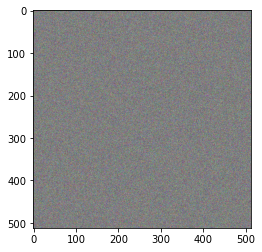

In [35]:
plt.imshow(unprep(s_rec[0]))

In [36]:
s_opt = torch.optim.LBFGS([s_rec])

In [37]:
s_stats = ans.Stats(0.)
s_stats.new_epoch()
s_rec_history = []

In [38]:
crit = torch.nn.MSELoss()
def s_closure():
    #################################################################
    # ZDE DOPLNIT
    
    s_rec_features = forward_ex(s_rec, vgg, s_layers)[1]
    s_rec_grams = {l: gramstat(s_rec_features[l]) for l in s_layers}
    s_loss = sum([crit(s_rec_grams[l], s_targets[l])*s_weights[idx] for idx, l in enumerate(s_layers)])
    s_losses_.append(float(s_loss))
    # zpetny pruchod
    s_opt.zero_grad()
    s_loss.backward()
    #################################################################

    return s_loss

In [66]:
pb = tqdm.tnrange(100)
for i in pb:
    s_losses_ = []
    s_opt.step(s_closure)
    
    s_stats.append_batch_stats('train', s_loss=np.mean(s_losses_))
    pb.set_postfix(loss='{:.3f}'.format(s_stats.ravg('train', 's_loss')), n_closures=len(s_losses_))
    if (i + 1) % 5 == 0:
        s_rec_history.append(unprep(s_rec[0]))

<ipython-input-66-be4c7f19ec8b>:1: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  pb = tqdm.tnrange(100)


  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

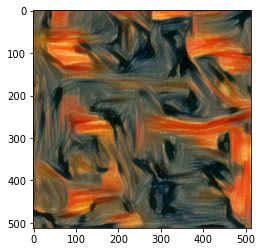

In [67]:
plt.imshow(unprep(s_rec[0]));

In [68]:
animate_history(s_rec_history)

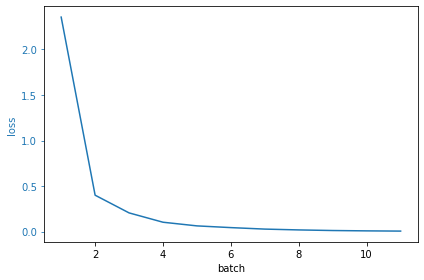

In [69]:
s_stats.plot_by_batch(left_metric='s_loss', right_metric=None, block_len=1)

## Kombinace obsahu a stylu: style transfer

Po rekonstrukci pouze z obsahu nebo stylu nyní obě kritéria spojíme a provedeme transfer stylu.

In [39]:
#################################################################
# ZDE DOPLNIT

t_rec = random_like(s_img)

#################################################################

t_rec.device, t_rec.dtype, t_rec.shape

(device(type='cuda', index=0), torch.float32, torch.Size([1, 3, 512, 512]))

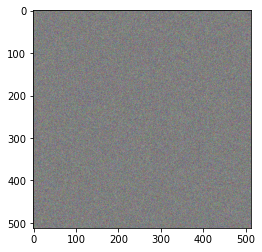

In [40]:
plt.imshow(unprep(t_rec[0]))

In [41]:
t_opt = torch.optim.LBFGS([t_rec])

In [42]:
t_stats = ans.Stats(0.)
t_stats.new_epoch()
t_rec_history = []

Celkové kritérium $L = \alpha L_c + \beta L_s$, kde $\alpha$ a $\beta$ jsou hyperparametry přiřazující obsahu a stylu různé váhy. Obrázek dole byl dosažen nastavením $\alpha=0.1$ a $\beta=1$. V původním článku se přitom uvádí poměry $\alpha/\beta = 10^{-4}\ldots 10^{-1}$. Rozdíl je daný tím, že v tomto notebooku byly váhy přeškálovány již výše, viz parametr $\omega$.

In [43]:
def t_closure():
    #################################################################
    # ZDE DOPLNIT
    
    t_layers = s_layers + c_layers
    t_rec_features = forward_ex(t_rec, vgg, t_layers)[1]
    t_rec_grams = {l: gramstat(t_rec_features[l]) for l in t_layers}
    
    c_loss = sum([crit(t_rec_features[l], c_targets[l]) for l in c_layers])
    s_loss = sum([crit(t_rec_grams[l], s_targets[l])*s_weights[idx] for idx, l in enumerate(s_layers)])
    t_loss = 0.1*c_loss + s_loss # celkovy loss jako vazena kombinace predchozich
    t_losses_.append((float(c_loss), float(s_loss), float(t_loss)))

    # zpetny pruchod
    t_opt.zero_grad()
    t_loss.backward()
    #################################################################

    return t_loss

In [44]:
pb = tqdm.tnrange(100)
for i in pb:
    t_losses_ = []    
    t_opt.step(t_closure)
    
    cl, sl, tl = np.mean(t_losses_, axis=0)
    t_stats.append_batch_stats('train', c_loss=cl, s_loss=sl, t_loss=tl)
    pb.set_postfix(
        c_loss='{:.3f}'.format(t_stats.ravg('train', 'c_loss')),
        s_loss='{:.3f}'.format(t_stats.ravg('train', 's_loss')),
        t_loss='{:.3f}'.format(t_stats.ravg('train', 't_loss'))
    )
    if (i + 1) % 5 == 0:
        t_rec_history.append(unprep(t_rec[0]))

<ipython-input-44-258ca14b8e57>:1: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  pb = tqdm.tnrange(100)


  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

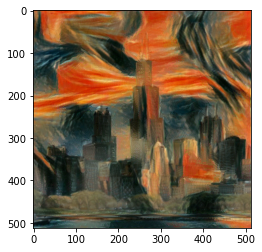

In [45]:
plt.imshow(unprep(t_rec[0]));

In [46]:
animate_history(t_rec_history)

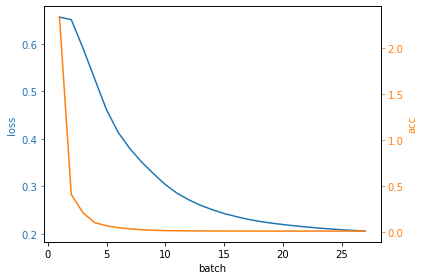

In [47]:
t_stats.plot_by_batch(left_metric='c_loss', right_metric='s_loss', block_len=1)